<a href="https://colab.research.google.com/github/dsevero/dsevero.com/blob/master/notebooks/On_Distributed_Quantization_for_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from toolz import pipe
from collections import defaultdict
from itertools import product

colors_hex = ['#FF0000', '#0000FF']
cm_bright = ListedColormap(colors_hex)

# 1. On-the-line quantizer

## 1.1 Generate data

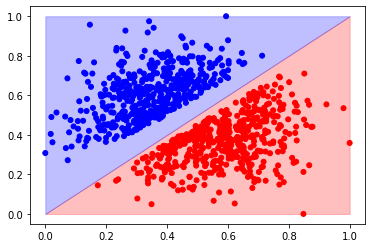

In [2]:
def _data_fixture():
    X = np.array([*[[0.2*i + 0.1, 0.2*(i+1)] for i in range(1, 5)],
                  *[[0.2*i + 0.1, 0.2*(i-1)] for i in range(1, 5)]])
    y = (X[:, 0] < X[:, 1]).astype(int)    
    return X, y

def normalize(X):
    x = X - X.min(axis=0)
    return x/x.max(axis=0)

def generate_data(N, separation=.25, seed=None):
    X = np.random.RandomState(seed).normal(size=(N, 2))
    y = (X[:, 0] < X[:, 1]).astype(int)
    X[y == 1, 0] -= separation
    X[y == 1, 1] += separation
    X[y == 0, 0] += separation
    X[y == 0, 1] -= separation
    X = normalize(X)
    y = (X[:, 0] < X[:, 1]).astype(int)
    return X, y

def make_potential_boundaries(X):
    return pipe(X, np.ravel, np.unique, np.sort)

def plot(X, y, boundaries=None):
    fig, ax = plt.subplots()
    ax.scatter(*X.T, c=y, s=25, cmap=cm_bright)
    x = np.linspace(0, 1, 100)
    ax.fill_between(x, x, 0, alpha=0.25, color=colors_hex[0])
    ax.fill_between(x, x, 1, alpha=0.25, color=colors_hex[1])

    if boundaries is not None:
        for b in boundaries:
            ax.vlines(b, 0, 1, linestyles='dashed')
            ax.hlines(b, 0, 1, linestyles='dashed')

    return fig, ax

X, y = generate_data(1000)
plot(X, y);

## 1.2 Algorithm

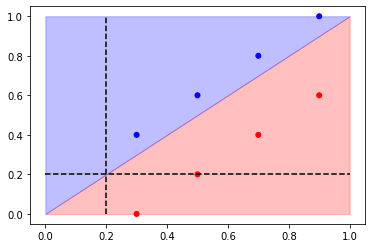

In [3]:
def _min_gap_error(X, y, si, sl=-1):
    mask = ((X > sl) & (X <= si)).all(axis=1)
    return min(((y == c) & mask).sum() for c in [0, 1])

def ontheline_quantizer(X, y, R):
    s = make_potential_boundaries(X)
    E = np.zeros((len(s), 2**R))
    A = defaultdict(lambda: defaultdict(set))
    for i, si in enumerate(s):
        E[i, 0] = _min_gap_error(X, y, si)

    for i, si in enumerate(s):
        for b in range(1, 2**R):
            if i == 0:
                E[i, b] = 0
                A[i][b] = set()
            else:
                (E[i, b],
                 l_star,
                 sl_star) = min([E[l, b-1] + _min_gap_error(X, y, si, sl), l, sl]
                                for l, sl in enumerate(s[:i]))
                A[i][b] = A[l_star][b-1].union({sl_star})

    return E, A, A[len(s)-1][2**R-1]

X, y = _data_fixture()
E, A, d = ontheline_quantizer(X, y, 1)
plot(X, y, d);

## 1.3 Sanity Checks

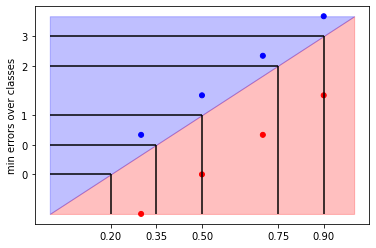

In [4]:
def test_zero_boundaries():
    X, y = _data_fixture()
    plot(X, y);
    boundaries = [0.20, 0.35, 0.50, 0.75, 0.90]
    errors = [0, 0, 1, 2, 3]
    for b, e in zip(boundaries, errors):
        assert _min_gap_error(X, y, b) == e
        plt.vlines(b, 0, b, linestyles='solid')
        plt.hlines(b, 0, b, linestyles='solid')
        plt.xticks(boundaries)
        plt.yticks(boundaries, labels=[f'{e}' for e in errors])
        plt.ylabel('min errors over classes')

test_zero_boundaries()

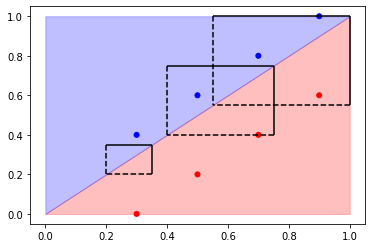

In [5]:
def draw_square(*edges):
    plt.vlines(edges[0], edges[0], edges[1], linestyles='solid')
    plt.vlines(edges[1], edges[0], edges[1], linestyles='dashed')
    plt.hlines(edges[0], edges[0], edges[1], linestyles='solid')
    plt.hlines(edges[1], edges[0], edges[1], linestyles='dashed')

def test_gap_boundaries():
    X, y = _data_fixture()
    plot(X, y);
    gaps = [(.35, .20), (.75, .40), (1.0, .55)]
    errors = [0, 0, 1]
    for g, e in zip(gaps, errors):
        assert _min_gap_error(X, y, *g) == e
        draw_square(*g)

test_gap_boundaries()

## 1.4 Run on separable data

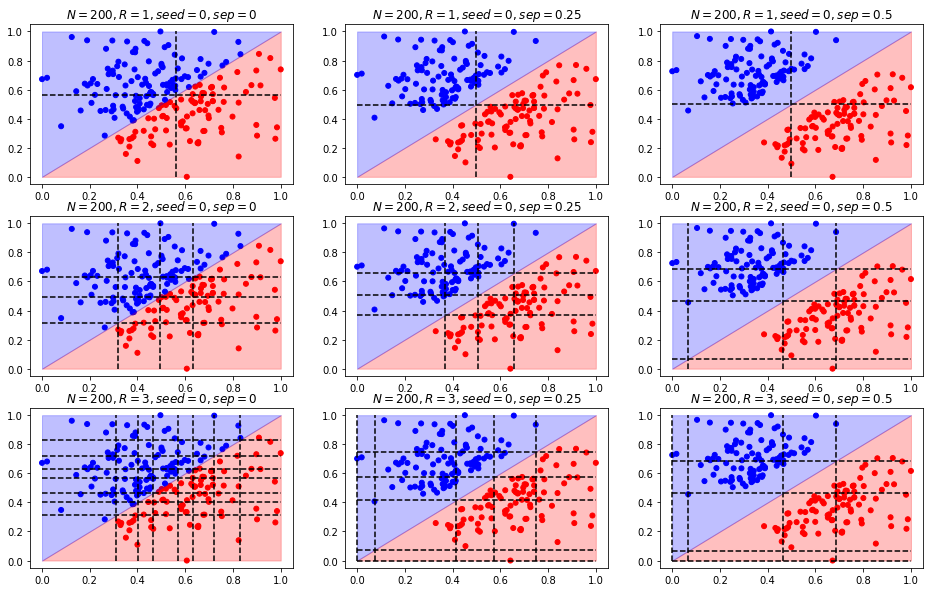

In [6]:
N = 200
seed = 0
R_space = [1, 2, 3]
sep_space = [0, 0.25, 0.5]

plt.figure(figsize=(16,10))
metrics = list()
for i, (R, separation) in enumerate(product(R_space, sep_space), 1):
    X, y = generate_data(N, separation, seed)
    E, A, boundaries = ontheline_quantizer(X, y, R)
    plt.subplot(3, 3, i)

    plt.scatter(*X.T, c=y, s=25, cmap=cm_bright)
    x = np.linspace(0, 1, 100)
    plt.fill_between(x, x, 0, alpha=0.25, color=colors_hex[0])
    plt.fill_between(x, x, 1, alpha=0.25, color=colors_hex[1])

    for b in boundaries:
        plt.vlines(b, 0, 1, linestyles='dashed')
        plt.hlines(b, 0, 1, linestyles='dashed')
    
    plt.title(f'$N={N}, R={R}, seed={seed}, sep={separation}$')

    metrics.append({'loss': E[-1][-1]/N,
                    'R': R,
                    'separation': separation})

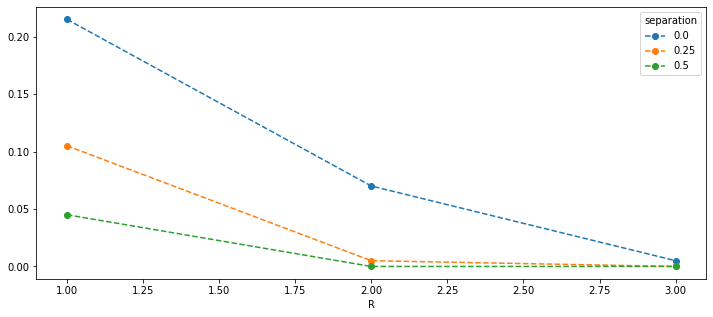

In [7]:
(pd
 .DataFrame(metrics)
 .pivot('R', 'separation', 'loss')
 .plot(style='o--', figsize=(12,5)));

# Questions
1. On-the-line quantizer minimizes reconstruction error, but does it minimize risk?

2. What if we perform block coding?